## Intro to Gnip
Gnip is a social media data aggregator that was purchased by Twitter in May 2014. We are the data pipeline to customers in over 40 countries who serve over 95% of the companies in the Fortune 500.  

## Data Science At Gnip
Gnip's data science team consists of five people with physcis and math backgrounds. We often get to work with enterprise level clients to find insights and develop solutions. Our team is focused on sharing our learning and we try to contribute to the open source community. 

With it's many libraries and continual development, Python continues to be our data science team's main language of choice. However, our team writes in serval languages. A typical workflow might start with simply using curl to pull in new data from Gnip's pipeline or else we might launch MapReduce jobs using Pig or Scala. We then massage the data using Python into a format that allows us to explore ideas and sometimes apply machine learning techniques. Depending on the project goals and size of data, we might make use SQL, R, or several Python libraries to find insights. 

We often build quick exploratory visualizations and share them inside IPython notebooks using Pandas and R. These notebooks allow us to easily create iterations, compare results, edit code on the fly, and even write explanations in markdown. We also regularly use R-studio, but Python based plotting tools (even those that allow us to directly write in R) are becomming more common. As IPython develops, I hope we'll see more opportunities to integrate with D3 - a favorite javascript library for building custom, interactive, web based visualizations.

Most of the data we explore is visualized using these graphs:
* Line graph (often used with time series)
* Bar graph (stacked, grouped, histogram)
* Scatter plot (often used to vary dimensions of color, label, and size)
* Cumulative Distribution Function plot 
* Probability Density Function plot 

Altering these visulaizations requires some know-how in these areas:
* Buckets (flexible aggregation techniques)
* Dates (slicing time series)
* Scales (representing regions of the data)

More advanced visualizations that we sometimes use:
* Choropleth (maps that tie geographic location to a scale)
* Networks (relationships among nodes)
* Hexbin (density plot)

## Team Culture & Visualization
Today we'll explore how team culture affects visualizations. As an example, we'll investigate Gnip's data science team.

This team holds two weekly events that promote learning: a quick standup and a weekly 45 mintue lecture series. The weekly tips & tricks standup generally showcases short snippets of code, command line utilities, or vim tricks that can advance the team's efficiency. The lecture series is a more indepth look at topic one member on the team is learning. The lecture is followed by 15 minutes of discussion. Both of these opportunities allow individuals on the team be  vulnerable with their expertise on a new topic. 

The weekly lectures and standups stabilize a share interest on our team: growth is necessary and desirable for all. The knowledge we build is something to which all parties contribute for the benefit of themselves and the team. 

These action dramatically impact our concept of an interative visualization process. 


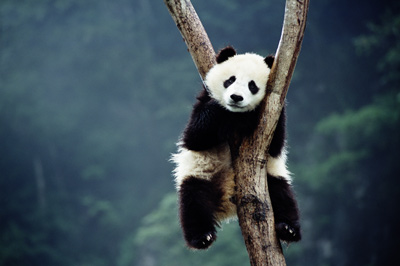

In [1]:
from IPython.display import Image
Image(filename='imgs/panda-sleep.jpg',width="80%") 

## Example 1: Pandas for Date Buckets
We find the pandas library useful and use it regularly. This specific example will focus on a common task for a data scientist: counting stuff. We will bucket the data and then count the number of events in each bucket.

In [2]:
# get data
#with open("data/sample1000_withHeader_zerosEdited.csv") as f:
#   x = f.readlines()
#for line in x[0:5]:
#    print line.strip()

In [3]:
# Load requirements 
import pandas as pd

# Make place inline as opposed to a separate window.
%matplotlib inline

#### Reading data
Let's start by opening a sample data file using Pandas. Typically, we would be gathering raw JSON, but here we have some previously parsed data to simplify the process. To understand the code below please see the [pd.read_csv() documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). 

In [4]:
# get data
df1 = pd.read_csv("data/sample1000_withHeader_zerosEdited.csv"
                      , sep = ","
                      , header = 0
                      , parse_dates = ["timeStamp"]
                      , encoding =  'utf-8'
                )
print type(df1)
print "df:\n{}".format(df1.tail())
# get data



<class 'pandas.core.frame.DataFrame'>
df:
              timeStamp     displayName  followersCount  followingCount  \
995 2014-10-26 19:41:13       macbaby98             828            2000   
996 2014-10-26 19:47:19       RyanIndy6             117             219   
997 2014-10-26 20:47:07    jenlawson123             732             393   
998 2014-10-26 22:21:36   armadillosoft            1259            1701   
999 2014-10-26 22:41:42  Wnicholasgomes           24149           26575   

     listedCount  statusesCount activityType             tweetID  
995            4          14775      Retweet  526458546238787585  
996            1            389        Tweet  526460083002408960  
997            1           9133        Tweet  526475132601368576  
998           77          38281        Tweet  526498910122950657  
999          113          76523      Retweet  526503968453963776  


#### Buckets
First, we have to decide on the size of our bucket. Since we're working with time series, we can focus on slices like day & hour. Below we have two methods for slicing our data. Each method produces different output, which will affect decisions that we'll make downstream. We can review a few conversations about [method 1](http://stackoverflow.com/questions/16266019/python-pandas-group-datetime-column-into-hour-and-minute-aggregations) and [method 2](https://github.com/pydata/pandas/issues/3791). Notice that the second method provides use with added information while preserving the date objects. 

In [5]:
# order dates
df1['timeStamp'] = df1.timeStamp.order()

# bucket data
## method 1
g1 = df1.groupby([df1.timeStamp.map(lambda t: t.day), df1.timeStamp.map(lambda t: t.hour)]).size()

## method 2
df2 = df1
g2 = df2.set_index("timeStamp").groupby([pd.TimeGrouper('1D'),pd.TimeGrouper('1H')]).size()

print "----------\nMethod 1\n----------\n{}\n\n\n\n----------\nMethod 2\n----------\n{}".format(g1.head(),g2.head())

----------
Method 1
----------
timeStamp  timeStamp
1          0            2
           1            3
           2            5
           3            2
           6            1
dtype: int64



----------
Method 2
----------
timeStamp   timeStamp          
2014-10-01  2014-10-01 00:00:00    2
            2014-10-01 01:00:00    3
            2014-10-01 02:00:00    5
            2014-10-01 03:00:00    2
            2014-10-01 06:00:00    1
dtype: int64


#### Iteration 1: the ol' .plot() method
Pandas methods sometimes seems like magic, which can be nice for a quick glance at the data. We can review documentation for [pandas.series.plot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.plot.html). 

timeStamp   timeStamp          
2014-10-01  2014-10-01 00:00:00    2
            2014-10-01 01:00:00    3
            2014-10-01 02:00:00    5
            2014-10-01 03:00:00    2
            2014-10-01 06:00:00    1
dtype: int64


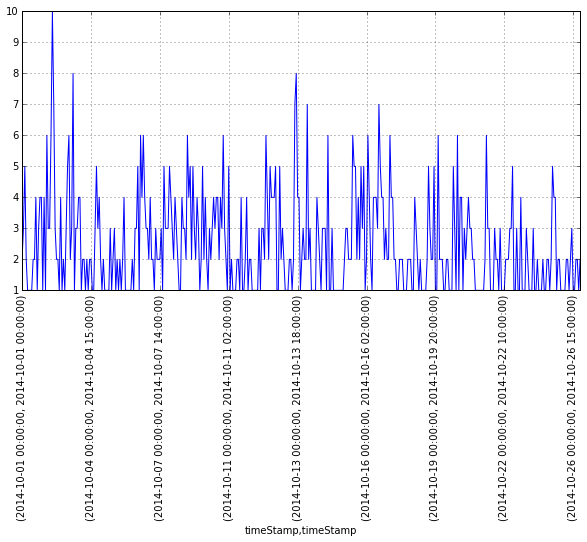

In [6]:
# glance at g2
print g2.head()

# dirty g2 graph
g2.plot(rot=90, figsize=(10,5))

## Example 2: R for Date Buckets
Let's clean this graph up a bit using ggplot in R. First, we'll load the data into python lists, build a pandas dataframe, and then pass this information to R whence we shall use the ggplot library to make a pretty graph. See the [yhat's explanation](http://ggplot.yhathq.com/how-it-works.html). 

In [7]:
# import requirments 
import rpy2
%load_ext rpy2.ipython
%R require("ggplot2")

# gather data for axes
dates = []
counts = g2.values
for tup in g2.keys().values:
    dates.append(tup[1])
#dir(g2)
#dir(g2.index)

# quick data check
print len(dates) == len(counts)
print "\ndates:\n{}\n\ncounts:\n{}".format(dates[:5],counts[:5])


Loading required package: stats
True

dates:
[Timestamp('2014-10-01 00:00:00', offset='H'), Timestamp('2014-10-01 01:00:00', offset='H'), Timestamp('2014-10-01 02:00:00', offset='H'), Timestamp('2014-10-01 03:00:00', offset='H'), Timestamp('2014-10-01 06:00:00', offset='H')]

counts:
[2 3 5 2 1]


In [8]:
# create dataframe with dates and counts 
dfR = pd.DataFrame({
        "xValues":dates,
        "yValues":counts
    })

# pass dfR to R
%Rpush dfR

#### Iteration 2: ggplot 
Changing the basic aesthetics and adding additional layers for template based graphs, ggplot is an R library packs some real explanatory power. See how it works from [yhat's perspecetive](http://ggplot.yhathq.com/how-it-works.html). Below you'll see the `%R` with a few paramaters. This code is explicitly R, not python; so when the cell executes, we see the results similar to a plot in R-studio.

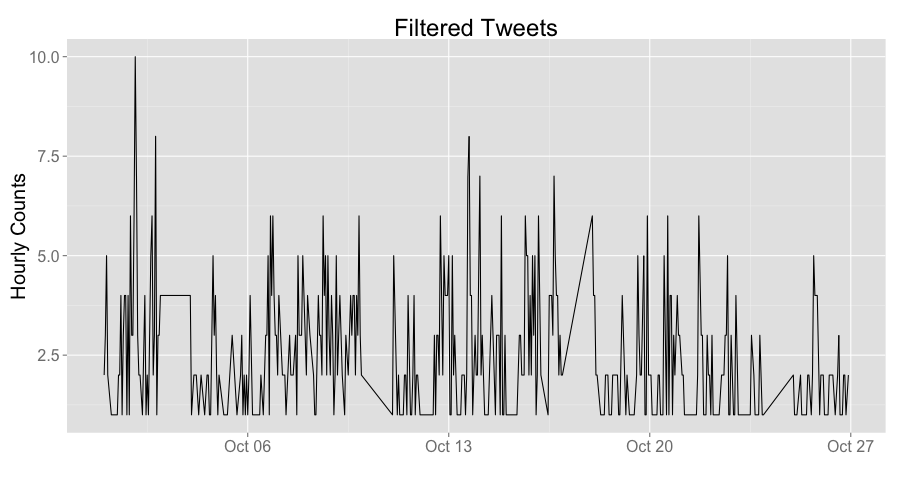

In [9]:
%%R -w 900 -h 480 -u px
#line graph in R
p1 <- ggplot(data=dfR) + geom_line(aes(x=xValues, y=yValues)) + ggtitle("Filtered Tweets") + xlab("") + ylab("Hourly Counts") + theme (legend.position="none", text = element_text(size=20))
print(p1)

##Example 3: D3 for Date Buckets
This example allows us to transform matplotlib plots to HTML. The advantage here is interactivity. Notice that we use the same code from example 1, but we gain the ability to zoom.

In [10]:
###
### FIX X AXIS DATES
###
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()


#### Iteration 3: D3
A simple matplotlib graph with some added functionality. 

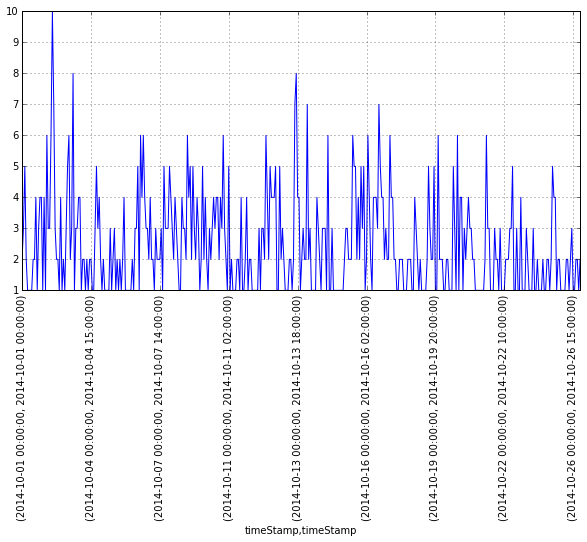

In [11]:
g2.plot(rot=90, figsize=(10,5))

## Example 4: D3 extended

In [ ]:
#...comming soon?